## NYU Machine Learning final project Algo I - SVM - Numpy Implementation

In this notebook, we will 

**(1) Write our own soft margin implementation of SVM using Numpy and cvxopt and test it on Iris Dataset**

**(2) Test it on Breast Cancer Dataset**

#### Import Iris Dataset 

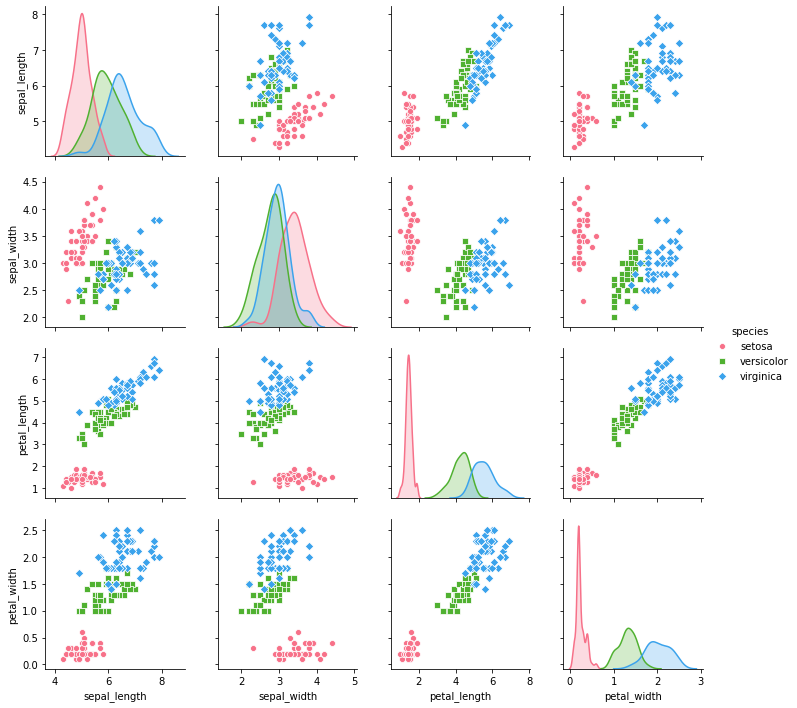

In [151]:
import seaborn as sns
# Load Iris data from Seaborn 
# Imported as Pandas DataFrame
iris = sns.load_dataset('iris')
# Plot pairplot to see the distribution of the data
sns.pairplot(iris,hue='species',palette="husl",markers=["o", "s", "D"])

**Make some changes to the Iris Data**

Since in the class we only covered binary classification for SVM in both our lecture and previous homework, in this extension we will only focus on binary SVM soft margin algorithm implementation. Thus, we will drop the Setosa species and focus on classify **Versicolor and Vriginica**. As from the distribution charts we can see that those two species are more difficult to be linearly seperate.  

In [154]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
X = iris.drop('species',axis=1)
y = iris['species']
#  Enlabel our y: 0 is setosa, 1 is Versicolor and  2 is Vriginica
le = preprocessing.LabelEncoder()
le.fit(y)
y_le = le.transform(y)
#  Since we will only do binary classfication, we drop the Setosa species and relabel 1 for Versicolor, -1 for Vriginica
ind = y_le>=1
x_2types = X[ind]
y_2types = y_le[ind]
y_2types= np.where(y_2types==2, -1, y_2types)
# Change X from datafram to numpy array
x_2types = x_2types.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(x_2types, y_2types, test_size=0.33, random_state = 42)
print("Our training and test data shapes:")
print("x_train dim and type: ", X_train.shape)
print("y_train dim and type: ", y_train.shape)
print("x_test dim and type: ", X_test.shape)
print("y_test dim and type: ", y_test.shape)

Our training and test data shapes:
x_train dim and type:  (67, 4)
y_train dim and type:  (67,)
x_test dim and type:  (33, 4)
y_test dim and type:  (33,)


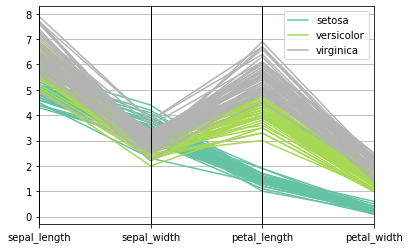

In [161]:
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates

parallel_coordinates(iris, 'species', colormap=plt.get_cmap("Set2"))
plt.show()

### Section 1: Using naive extended algorithm on the Iris Dataset

In homework9, we implemented hard margin SVM and solved both primal and dual problems. 
In this project, we will focus on solving soft margin dual problems as most datasets in real life are not linearly separable. 

Remember in **hard margin SVM case**, constrained optimization problem **(primal)** is:
$$min\frac{1}{2}||w||_2^2 $$
$$ \textrm{s.t.} \quad y^{(i)} (w_0+w^Tx^{(i)})\geq1 
\\\textrm{for all i = 1, 2....,N } $$ 

And after we transform our original problem into its **duel** formalization, adding Lagrangian multiplier, we have a dual optimization problem that is:

$$min_{\alpha}\frac{1}{2} \alpha^{T}Q\alpha - 1^{T}\alpha $$$$ \textrm{s.t.}\quad \alpha_{i} \ge 0 \quad \forall i \\\ \textrm{and}\quad y^{T}\alpha = 0$$

The hard margin SVM has its limit as it assumes that our data is linearly separable. But what if we have a few misclassified data or data points that within the margin? 

Then we extend to the **soft margin SVM case** -- which introduces a new **tolerance variable (or slack variable) $\zeta_{(i)}$for each training example $x_{(i)}$**. Points that lie on the margin will have $\zeta_{(i)} = 0$. On the other hand, the farther we are from the correct boundary, the larger the value of $\zeta_{(i)}$ will be larger. 

> <img src="svm_soft_margin.png" height="400" width="400">
(source: https://sandipanweb.wordpress.com/2018/04/23/implementing-a-soft-margin-kernelized-support-vector-machine-binary-classifier-with-quadratic-programming-in-r-and-python/)

Thus, our optimization function would be:
$$min\frac{1}{2}||w||_2^2  + C \sum_{i = 1}^N\zeta^{(i)}$$
$$ \textrm{s.t.} \quad y^{(i)} (w_0+w^Tx^{(i)})\geq1 -\zeta^{(i)}
\\\textrm{for all i = 1, 2....,N } $$
$$\zeta^{(i)}\geq0$$

**Notice here C is atunable parameter, gives relative importance of the error term.It controls how much you want to punish your model for each misclassified point for a given curve. The lower the C parameters, the softer the margin.**
 

After adding the Lagrangian multiplier,do the kernel trick, then we have the **SVM soft margin dual quadratic programming problem**:

 $$min_{\alpha} \frac{1}{2} \sum_{i,j = 1}^m\alpha_i\alpha_jy_iy_jK(x_i,x_j) -\sum_{i=1}^m\alpha_i\quad\\ \textrm{s.t.}\quad C\ge\alpha_{i} \ge 0 \quad 
\\\quad\sum_{i=1}^m\alpha_{i}y_i = 0$$



Then, we use CVXOPT, the quadratic programming problem solver, cvxopt.solvers.qp to solve this problem.

We can see this is very similar to the homework's problem of dual for hard margin besides we have an additional constraint on $\alpha$. When using CVXOPT's quadratic solver, we implement this constraint by concatenating below matrix G a diagonal matrix of 1s of size mÃ—m and adding m times value ot C vo vector h.

> Reference: https://courses.csail.mit.edu/6.867/wiki/images/a/a7/Qp-cvxopt.pdf

In [332]:
# Please make sure you've installed CVXOPT
# If not, do:
# !pip3 install cvxopt
from cvxopt import matrix, solvers
import numpy as np

In [333]:
# This is the dual problem solution for soft margin SVM
def soft_dual_svm(X,y,C):
    solvers.options['show_progress'] = False
    NUM,DIM = X.shape
    y = y.reshape(-1,1) * 1.
    temp = y * X
    H = np.dot(temp , temp.T) * 1.
#   Match vectors to the CVXOPT's matrix format: 
    P = matrix(H)
    q = matrix(-np.ones((NUM, 1)))
    G = matrix(np.vstack((np.eye(NUM)*-1,np.eye(NUM))))
    h = matrix(np.hstack((np.zeros(NUM), np.ones(NUM) * C)))
    A = matrix(y.reshape(1, -1))
    b = matrix(np.zeros(1))
#   Use CVXOPT's quadratic peoblem solver -> the returned solutions are the values of all alphas
    result = solvers.qp(P, q, G, h, A, b)
    alphas = np.array(result['x'])
    w = ((y * alphas).T @ X).reshape(-1,1)   
    alpha = (alphas > 1e-3).flatten()
    b = y[alpha] - np.dot(X[alpha], w)
    return w,b,alphas

Get $w$, $w_0$ and $\alpha$ when $C = 1.5$ using the below function

In [340]:
w,b,alphas = soft_dual_svm(X_train,y_train ,1.5)
# print('alphas = ',alphas)
print('w = ', w.flatten())
print('b = ', b[0])

w =  [ 1.1725151   4.02254107 -4.24359542 -7.15215218]
b =  [14.45316144]


The **decision function for dual problem** is $f_{\texttt{dual}}({\bf x})=
\left(\sum_{i\in I}
\alpha^{(i)}y^{(i)}
K({\bf x}^{(i)},{\bf x})
\right)+w_0$ 
where $I = \{i\mid \alpha^{(i)}\not = 0\}$.  
In this extension, we will use a linear kernel function. 

In [341]:
def lin_kernel(xi, xj):
    return np.dot(xi,xj)

In [342]:
def f_dual(xx,alphas,b,X_train,y_train):
    sum = 0
    for i in range(X_train.shape[0]):
        sum+=y_train[i]*alphas[i]*lin_kernel(X_train[i].transpose(),xx)
    sum+=b[0]
    result = sum
#     print(result)
    if result >0:
        return 1
    else:
        return -1   
    return result

In [343]:
def predict(X_test,y_test,alphas,b,X_train,y_train):
    predicted_y = np.zeros(len(X_test))
    for i in range(len(X_test)):
        predicted_y[i]=f_dual(X_test[i],alphas,b,X_train,y_train)
    correct = 0
    for j in range(len(y_test)):
        if predicted_y[j] == y_test[j]:
            correct += 1
    acc = float(correct/len(y_test))
#     print("Correctly predicted test data number is ", correct)
#     print("Accuracy on test data is ", acc)
    return acc
    

In [344]:
predict(X_test,y_test,alphas,b,X_train,y_train)

0.8787878787878788

In [346]:
c_values =[1.5,5,10,20,30,40,50,60,70,80,90,100]
acc = []
for val in c_values:
    w,b,alphas = soft_dual_svm(X_train,y_train,val)
    a = predict(X_test,y_test,alphas,b,X_train,y_train)
    acc.append(a)
print(acc)   

[0.9393939393939394, 0.9090909090909091, 0.8484848484848485, 0.8484848484848485, 0.8787878787878788, 0.8787878787878788, 0.8787878787878788, 0.8787878787878788, 0.8787878787878788, 0.8787878787878788, 0.8787878787878788, 0.8787878787878788]


**Let's see how our C value (size of margin affect our accuracy)**

As we metioned before: **C is a regularization parameter for SVMs, it controls how much you want to punish your model for each misclassified point for a given curve. The lower the C parameters, the softer the margin.**
 

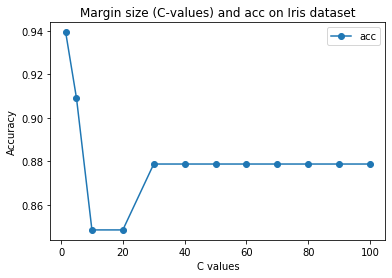

In [354]:
# Plot scores on Test set
from matplotlib import pyplot as plt
df=pd.DataFrame({'c_value':c_values, 'acc': acc })

plt.plot( 'c_value', 'acc', data=df, linestyle='-', marker='o')
plt.ylabel("Accuracy")
plt.xlabel("C values")
plt.legend()
plt.title("Margin size (C-values) and acc on Iris dataset")
plt.show()


#### From the chart above, we can see that as the C value increase --> we get a harder margin, the accuracy decrease for our test Iris dataset.

### Section 2: Using naive extended algorithm on the Breast Cancer Dataset

In [369]:
from sklearn.datasets import load_breast_cancer # The breast cancer data set is in scikit learn data set
import pandas as pd
data_breast_cancer = load_breast_cancer()
X2 = data_breast_cancer.data
y2 = data_breast_cancer.target
y_2= np.where(y2==0, -1, y2)

In [370]:
print("X2 dim and type: ", X2.shape,X2.dtype)
print("y2and type: ", y2.shape,y2.dtype)

X2 dim and type:  (569, 30) float64
y2and type:  (569,) int64


In [371]:
#Split the data into training and test set.  80% training and %20 test
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y_2, test_size=0.2)

In [372]:
w2,b2,alphas2 = soft_dual_svm(X2_train,y2_train,1.5)
# print('alphas = ',alphas)
print('w = ', w2.flatten())
print('b = ', b2[0])

w =  [ 1.77578483e+00  6.93523180e-03 -1.10827052e-01 -3.07622795e-03
 -2.88860217e-01 -2.87516101e-01 -1.00907596e+00 -5.25898994e-01
 -3.82387858e-01 -1.22550171e-02  1.22379790e-02  3.77728359e-01
  5.78853652e-01 -5.68404438e-02 -7.62848173e-02  4.27734316e-02
 -2.51673747e-01 -9.50834796e-02 -9.48525047e-02  1.27470251e-02
 -3.55330092e-04 -1.67673698e-01 -1.20620849e-01 -3.86395411e-03
 -5.13020743e-01 -3.59605807e-01 -2.14701622e+00 -8.78893062e-01
 -7.37480539e-01 -6.06760932e-02]
b =  [9.22689821]


In [373]:
my_acc = predict(X2_test,y2_test,alphas2,b2,X2_train,y2_train)
print("When C=1.5, our soft margin svm model achieved an accuracy of :", my_acc)


When C=1.5, our soft margin svm model achieved an accuracy of : 0.9473684210526315


**Let's see how our C value (size of margin affect our accuracy)**

In [379]:
c_values_2 =[1.5,10,20,30,50,100,500,1000]
acc_2 = []
for val in c_values_2:
    w2,b2,alphas2 = soft_dual_svm(X2_train,y2_train,val)
    a = predict(X2_test,y2_test,alphas2,b2,X2_train,y2_train)
    acc_2.append(a)
print(acc_2)  

[0.9473684210526315, 0.9473684210526315, 0.9385964912280702, 0.9473684210526315, 0.956140350877193, 0.956140350877193, 0.956140350877193, 0.9473684210526315]


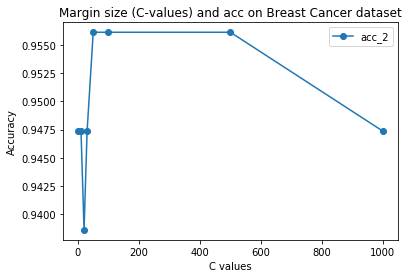

In [380]:
# Plot scores on Test set
from matplotlib import pyplot as plt
df=pd.DataFrame({'c_value_2':c_values_2, 'acc_2': acc_2 })

plt.plot( 'c_value_2', 'acc_2', data=df, linestyle='-', marker='o')
plt.ylabel("Accuracy")
plt.xlabel("C values")
plt.legend()
plt.title("Margin size (C-values) and acc on Breast Cancer dataset")
plt.show()

#### From the chart above, different from the Iris data set, we can see that the accuracy first goes up and then goes down as we increase the C value. 
#### One possible exmplaination is at the beigining we have very small penalty so that there's a under fitting problem 
